In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense



In [6]:
base_dir = "../data/classification_dataset"

train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")


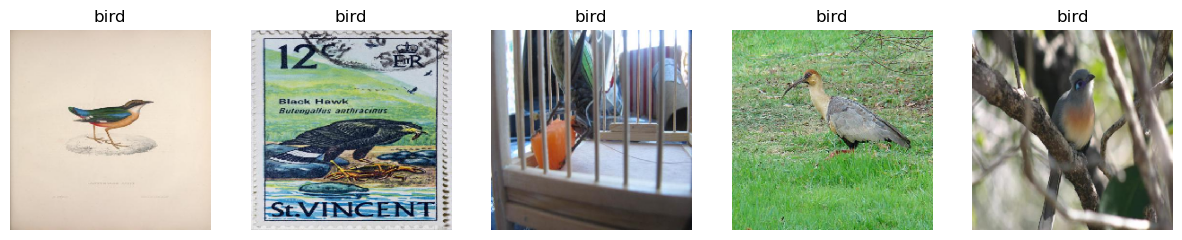

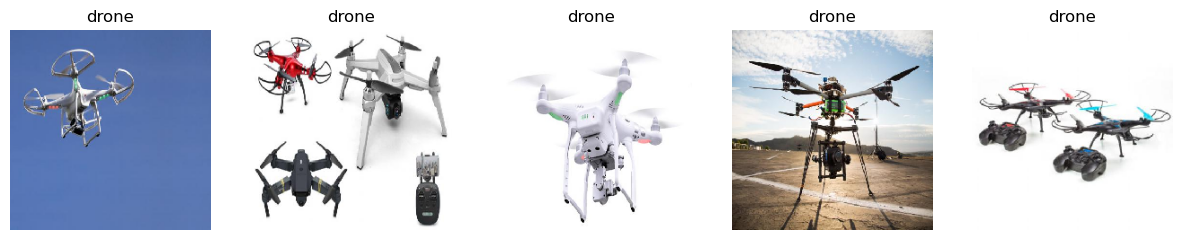

In [8]:
def visualize_samples(folder, class_name, n=5):
    class_path = os.path.join(folder, class_name)
    images = os.listdir(class_path)[:n]
    plt.figure(figsize=(15,3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(224,224))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

visualize_samples(train_dir, "bird")
visualize_samples(train_dir, "drone")


#data augmentation and building data generators
# Training data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

# Validation & Test: only normalize
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (160, 160)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "../data/classification_dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    "../data/classification_dataset/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3) (32,)


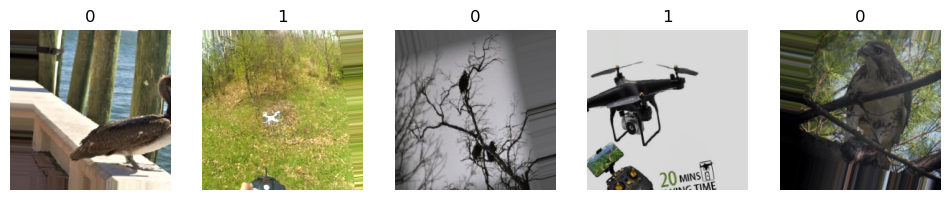

In [68]:
#inspection

x_batch, y_batch = next(train_generator)
print("Batch shape:", x_batch.shape, y_batch.shape)

plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_batch[i])
    plt.title(int(y_batch[i]))
    plt.axis('off')
plt.show()


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np



In [16]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0,1]),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.9413012729844413, 1: 1.0665064102564104}


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(160,160,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 79, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 128)     

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_cnn_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [32]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)




Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.6529
Epoch 1: val_accuracy improved from -inf to 0.71493, saving model to best_cnn_model.h5
84/84 [==============================] - 22s 252ms/step - loss: 0.6367 - accuracy: 0.6529 - val_loss: 0.5616 - val_accuracy: 0.7149
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7476
Epoch 2: val_accuracy improved from 0.71493 to 0.73303, saving model to best_cnn_model.h5
84/84 [==============================] - 23s 268ms/step - loss: 0.5149 - accuracy: 0.7476 - val_loss: 0.5492 - val_accuracy: 0.7330
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.7776
Epoch 3: val_accuracy improved from 0.73303 to 0.77149, saving model to best_cnn_model.h5
84/84 [==============================] - 23s 277ms/step - loss: 0.4611 - accuracy: 0.7776 - val_loss: 0.4695 - val_accuracy: 0.7715
Epoch 4/30
84/84 [==============================] - ETA

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [34]:
from tensorflow.keras.models import load_model

best_model = load_model("best_cnn_model.h5")


In [36]:
best_model.evaluate(val_gen)


14/14 [==============================] - 1s 67ms/step - loss: 0.5169 - accuracy: 0.8416


[0.516922652721405, 0.8416289687156677]

In [56]:
import numpy as np

val_gen.reset()
y_pred_prob = best_model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()



y_true = val_gen.classes


14/14 [==============================] - 1s 75ms/step


In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm


array([[193,  24],
       [ 46, 179]])

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


              precision    recall  f1-score   support

        bird       0.81      0.89      0.85       217
       drone       0.88      0.80      0.84       225

    accuracy                           0.84       442
   macro avg       0.84      0.84      0.84       442
weighted avg       0.85      0.84      0.84       442



In [64]:
model.save("final_cnn_bird_drone.keras")
